In [103]:
import pandas as pd

# Importer les fichiers
x_train = pd.read_csv('data/train_f_x.csv')
y_train = pd.read_csv('data/y_train_sncf.csv')

In [104]:
x_train.head()
print(x_train.shape)

(1229863, 5)


In [105]:
y_train.head()

,index,y
0,2015-01-01_1J7,7
1,2015-01-01_O2O,0
2,2015-01-01_8QR,9
3,2015-01-01_UMC,9
4,2015-01-01_FK3,28


In [106]:
# Extraire la date et la station de l'index dans y_train
y_train[['date', 'station']] = y_train['index'].str.split('_', expand=True)

In [107]:
# Convertir les dates en format datetime
x_train['date'] = pd.to_datetime(x_train['date'])
y_train['date'] = pd.to_datetime(y_train['date'])

In [108]:
# Fusionner x_train et y_train
train_df = pd.merge(x_train, y_train, on=['date', 'station'])

# Exploration initiale
train_df.head()

,date,station,job,ferie,vacances,index,y
0,2015-01-01,1J7,1,1,1,2015-01-01_1J7,7
1,2015-01-01,O2O,1,1,1,2015-01-01_O2O,0
2,2015-01-01,8QR,1,1,1,2015-01-01_8QR,9
3,2015-01-01,UMC,1,1,1,2015-01-01_UMC,9
4,2015-01-01,FK3,1,1,1,2015-01-01_FK3,28


In [109]:
train_df.shape

(1229863, 7)

In [110]:
# Définir les dates de début et de fin de la période à exclure
start_date = pd.Timestamp('2020-03-01')
end_date = pd.Timestamp('2020-09-01')

# Filtrer les données pour exclure la période spécifiée
train_df = train_df[(train_df['date'] < start_date) | (train_df['date'] >= end_date)]

In [111]:
# Créer des variables dummies pour les jours de la semaine
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df = pd.get_dummies(train_df, columns=['day_of_week'], drop_first=True)


train_df.head()

,date,station,job,ferie,vacances,index,y,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2015-01-01,1J7,1,1,1,2015-01-01_1J7,7,False,False,True,False,False,False
1,2015-01-01,O2O,1,1,1,2015-01-01_O2O,0,False,False,True,False,False,False
2,2015-01-01,8QR,1,1,1,2015-01-01_8QR,9,False,False,True,False,False,False
3,2015-01-01,UMC,1,1,1,2015-01-01_UMC,9,False,False,True,False,False,False
4,2015-01-01,FK3,1,1,1,2015-01-01_FK3,28,False,False,True,False,False,False


In [112]:
# Fonction pour vérifier si une date est pendant les grandes vacances
def is_summer_holiday(date):
    return (date.month == 7) or (date.month == 8) 

# Fonction pour vérifier si une date est pendant les vacances de Noël
def is_christmas_holiday(date):
    return (date.month == 12 and date.day >= 20) or (date.month == 1 and date.day <= 1)

In [113]:
# Appliquer les fonctions pour créer les nouvelles colonnes
train_df['summer_holiday'] = train_df['date'].apply(is_summer_holiday)
train_df['christmas_holiday'] = train_df['date'].apply(is_christmas_holiday)

# Convertir les colonnes en types int (0 ou 1) pour les utiliser comme features
train_df['summer_holiday'] = train_df['summer_holiday'].astype(int)
train_df['christmas_holiday'] = train_df['christmas_holiday'].astype(int)


In [114]:
train_df['other_holiday'] = ((train_df['vacances'] == 1) & 
                             (train_df['summer_holiday'] == 0) & 
                             (train_df['christmas_holiday'] == 0)).astype(int)

In [115]:
# Ajouter une tendance temporelle
train_df['trend'] = (train_df['date'] - train_df['date'].min()).dt.days

# Vérifier la structure des données après ajout des variables
train_df.tail()

,date,station,job,ferie,vacances,index,y,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,summer_holiday,christmas_holiday,other_holiday,trend
1229858,2022-12-31,V2P,0,0,1,2022-12-31_V2P,1227,False,False,False,False,True,False,0,1,0,2921
1229859,2022-12-31,N9K,0,0,1,2022-12-31_N9K,544,False,False,False,False,True,False,0,1,0,2921
1229860,2022-12-31,P6E,0,0,1,2022-12-31_P6E,92,False,False,False,False,True,False,0,1,0,2921
1229861,2022-12-31,BDC,0,0,1,2022-12-31_BDC,91,False,False,False,False,True,False,0,1,0,2921
1229862,2022-12-31,W14,0,0,1,2022-12-31_W14,18,False,False,False,False,True,False,0,1,0,2921


In [116]:
from sklearn.preprocessing import PolynomialFeatures

# Créer des termes polynomiaux pour la variable de tendance
poly = PolynomialFeatures(degree=3, include_bias=False)
trend_features = poly.fit_transform(train_df[['trend']])

# Ajouter les termes polynomiaux au DataFrame
for i in range(trend_features.shape[1]):
    train_df[f'trend_poly_{i+1}'] = trend_features[:, i]

In [117]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Liste pour stocker les prédictions et les coefficients
predictions = []
coefficients = {}

# Entraîner un modèle de régression linéaire pour chaque station
stations = train_df['station'].unique()
for station in stations:
    station_data = train_df[train_df['station'] == station]
    
    # Variables explicatives
    X = station_data[['job', 'ferie', 'summer_holiday', 'christmas_holiday', 'other_holiday','trend_poly_1','trend_poly_2','trend_poly_3'] + [col for col in station_data.columns if 'day_of_week_' in col]]
    y = station_data['y']
    
    # Modèle de régression linéaire
    model = LinearRegression()
    model.fit(X, y)
    
    # Prédictions
    y_pred = model.predict(X)
    predictions.append(y_pred)
    
    # Stocker les coefficients et l'intercept
    coefficients[station] = {
        'intercept': model.intercept_,
        'coefficients': model.coef_,
        'feature_names': X.columns
    }

# Convertir les prédictions en un DataFrame
train_df['y_pred'] = np.concatenate(predictions)

# Afficher les coefficients pour chaque station
for station, coef_data in coefficients.items():
    print(f"Station: {station}")
    print(f"Intercept: {coef_data['intercept']}")
    for feature, coef in zip(coef_data['feature_names'], coef_data['coefficients']):
        print(f"Feature: {feature}, Coefficient: {coef}")
    print("\n")


Station: 1J7
Intercept: -52.95938087332249
Feature: job, Coefficient: 73.43380819812934
Feature: ferie, Coefficient: -83.37777600126152
Feature: summer_holiday, Coefficient: -14.330599577172743
Feature: christmas_holiday, Coefficient: -37.01349694508283
Feature: other_holiday, Coefficient: -7.069434157356864
Feature: trend_poly_1, Coefficient: 0.25402110025045116
Feature: trend_poly_2, Coefficient: -0.00012580519314239064
Feature: trend_poly_3, Coefficient: 1.9027950770578173e-08
Feature: day_of_week_1, Coefficient: 2.5978081609704478
Feature: day_of_week_2, Coefficient: -9.713861724994382
Feature: day_of_week_3, Coefficient: -7.3793807681243475
Feature: day_of_week_4, Coefficient: -23.818904963030917
Feature: day_of_week_5, Coefficient: -38.01490445307997
Feature: day_of_week_6, Coefficient: -35.41890374503705


Station: O2O
Intercept: 6.844379188771196
Feature: job, Coefficient: 10.341385602278688
Feature: ferie, Coefficient: -11.243355183521839
Feature: summer_holiday, Coefficient: 

In [118]:
train_df.head(20)

,date,station,job,ferie,vacances,index,y,day_of_week_1,day_of_week_2,day_of_week_3,...,day_of_week_5,day_of_week_6,summer_holiday,christmas_holiday,other_holiday,trend,trend_poly_1,trend_poly_2,trend_poly_3,y_pred
0,2015-01-01,1J7,1,1,1,2015-01-01_1J7,7,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,-107.296226
1,2015-01-01,O2O,1,1,1,2015-01-01_O2O,0,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,-46.853171
2,2015-01-01,8QR,1,1,1,2015-01-01_8QR,9,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,-82.872864
3,2015-01-01,UMC,1,1,1,2015-01-01_UMC,9,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,52.421989
4,2015-01-01,FK3,1,1,1,2015-01-01_FK3,28,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,64.611297
5,2015-01-01,I1K,1,1,1,2015-01-01_I1K,16,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,29.009018
6,2015-01-01,KY6,1,1,1,2015-01-01_KY6,416,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,-66.264243
7,2015-01-01,V8D,1,1,1,2015-01-01_V8D,28,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,-80.623962
8,2015-01-01,EK4,1,1,1,2015-01-01_EK4,53,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,102.520135
9,2015-01-01,357,1,1,1,2015-01-01_357,9,False,False,True,...,False,False,0,1,0,0,0.0,0.0,0.0,139.695544


In [119]:
# Calculer la MAPE pour évaluer le modèle
train_df['ape'] = np.abs((train_df['y'] - train_df['y_pred']) / train_df['y'])
mape = train_df['ape'].mean()
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Percentage Error (MAPE): inf


In [120]:
from sklearn.metrics import mean_absolute_percentage_error

# Calcul du MAPE
epsilon = 1  # Petite constante pour éviter la division par zéro
y_true = train_df['y'].replace(0, epsilon)  # Remplacer les zéros par epsilon
y_pred = train_df['y_pred']
mape_lr = mean_absolute_percentage_error(y_true, y_pred)
print(f'MAPE du modèle de régression linéaire: {mape_lr}')

MAPE du modèle de régression linéaire: 53.384046417046896


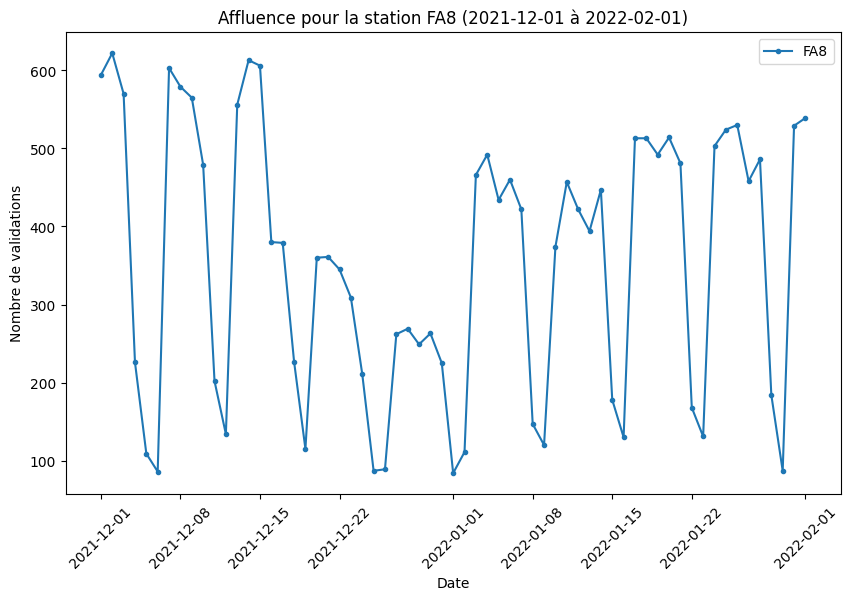

In [121]:
def plot_station_affluence(station_code, start_date=None, end_date=None):
    station_data = train_df[train_df['station'] == station_code].sort_values(by='date')
    
    # Filtrer par date si les dates de début et de fin sont fournies
    if start_date is not None:
        station_data = station_data[station_data['date'] >= start_date]
    if end_date is not None:
        station_data = station_data[station_data['date'] <= end_date]
    
    plt.figure(figsize=(10, 6))
    plt.plot(station_data['date'], station_data['y'], label=station_code, marker='o', linestyle='-', markersize=3)
    plt.xlabel('Date')
    plt.ylabel('Nombre de validations')
    plt.title(f'Affluence pour la station {station_code} ({start_date} à {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Exemple d'utilisation de la fonction
plot_station_affluence('FA8', '2021-12-01', '2022-02-01')




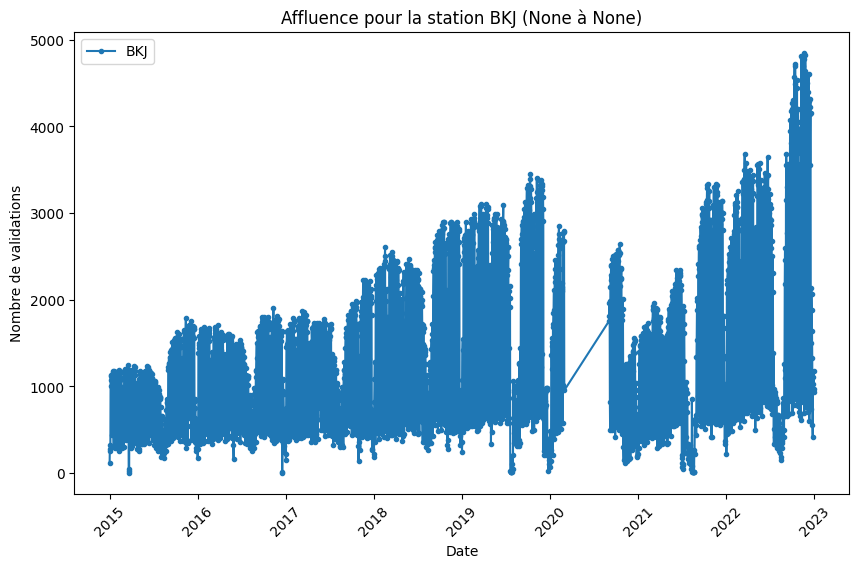

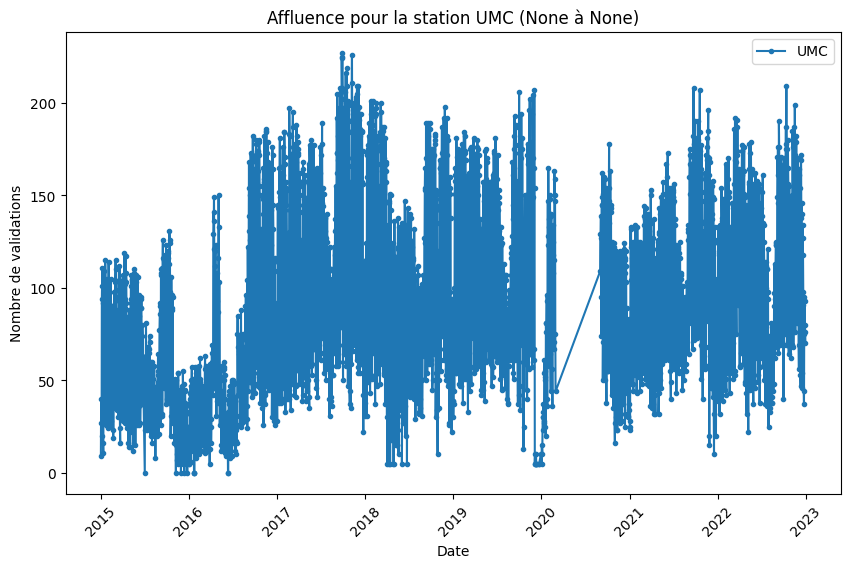

In [122]:
# Exemple : Tracer le graphique pour une station spécifique
plot_station_affluence('BKJ')
plot_station_affluence('UMC')

In [124]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error

# Sélection des variables explicatives
features = ['job', 'ferie', 'vacances', 'summer_holiday', 'christmas_holiday', 'other_holiday'] + \
           [col for col in train_df.columns if 'trend_poly_' in col]

X = train_df[features]
y = train_df['y']

# Séparation des données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calcul du MAPE
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

MAPE sur les données d'entraînement: 6.494016062722926e+16
MAPE sur les données de test: 6.3712736033256136e+16


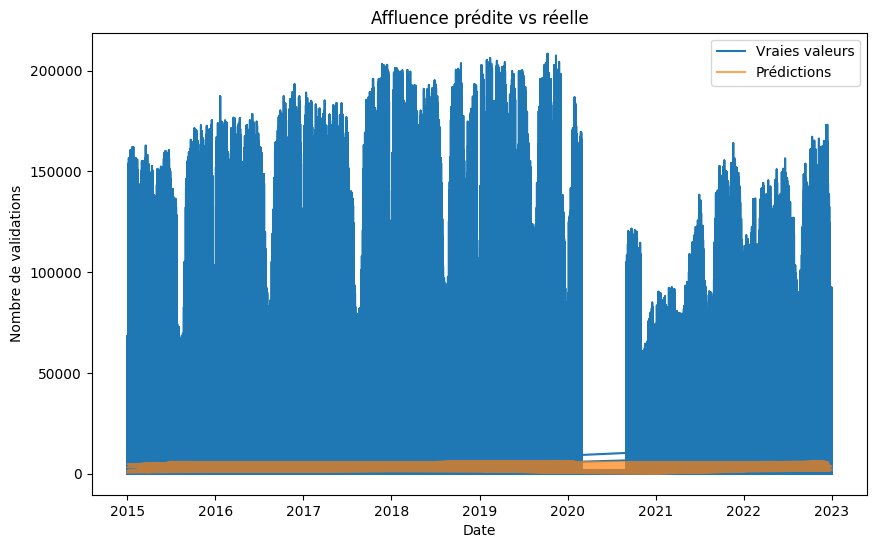

In [125]:
print(f'MAPE sur les données d\'entraînement: {mape_train}')
print(f'MAPE sur les données de test: {mape_test}')

# Graphique des résultats
plt.figure(figsize=(10, 6))
plt.plot(train_df['date'], train_df['y'], label='Vraies valeurs')
plt.plot(train_df['date'], model.predict(X), label='Prédictions', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Nombre de validations')
plt.title('Affluence prédite vs réelle')
plt.legend()
plt.show()